In [ ]:
import math

c_dict = {
    4: 64, #8,
    6: 37.5, #3
}

cidr_max = {
    4: 28,
    6: 48
}

def __get_min_samples(ip_version, mask):

    c= c_dict[ip_version]

    
    if ip_version == 4:
        ipv_max = 32
        min_samples=int(c * math.sqrt( math.pow(2, (ipv_max - mask))))
    elif ip_version == 6:
        ipv_max = 64
        min_samples=int(c * math.sqrt(math.sqrt( math.pow(2, (ipv_max - mask)))))
    else:
        pass

    # TODO für später
    

    # bei v6 doppelte wurzel

    # self.logger.info(f"min samples: {min_samples}")
    return min_samples

for i in range(0, cidr_max[4]):
    print(f"4 {i}:\t{__get_min_samples(4,i)}")

for i in range(0, cidr_max[6]):
    print(f"6 {i}:\t{__get_min_samples(6,i)}")

In [ ]:
from netaddr import IPNetwork, IPAddress
import pytricia
from collections import defaultdict

def join_siblings(ip_version, mask, prange):

    ## check if join would be possible
    if mask == 0:
        print("        join siblings not possible - we are at the root of the tree")
        return None


    nw = IPNetwork(f"{prange}/{mask}")


    #### GET SUPERNET
    nw_supernet=nw.supernet(mask-1)[0]
    supernet_ip=str(nw_supernet).split("/")[0]
    supernet_mask=int(str(nw_supernet).split("/")[1])

    siblings=list(nw_supernet.subnet(mask))
    print(f"join_siblings supernet: {nw_supernet}")
    print(f" siblings: {siblings}")

join_siblings(6,48,"2a05:d018:1::" )

p = pytricia.PyTricia(48)
p.insert("0:0:2::/48","0:0:2::/48",)
p.insert("2a05:d018::/48", "2a05:d018::/48")
p.insert("2a05:d018:8000::/48", "2a05:d018:8000::/48")
p.insert("2a05:d018:1::/48", "2a05:d018:1::/48")


print("lpm: ", list(p))

for i in ["2a05:d018:1::", "2a05:d018:dc0::", "2a05:d018:76c::", "2a05:d018:5::", "2a05:d018:4e8::"]:
    try:
        print(p[i])
    except:
        print(f"prefix not found: {i}")


d = defaultdict(int)
d["0:0:2::/48"] = 5

print(d)
d.pop("0:0:2::/48",)


In [ ]:
from clickhouse_driver import Client

cl = Client('localhost')

query='''
select
    netid_string1,
    --has_smaller_as,
    --has_bigger_as,
    --origins_net1_in_net2,
    --origins_net2_in_net1,
    1
from (
        select
            netid_string1,
            (
                select
                    tuple (
                        groupArray(substring(netid_string, 8)), --ipv4 only.
                        groupArray(mask),
                        groupArray(origin)
                    )
                from
                    ipd.prefix_as__v
                where
                    origin > 0
                    and netid_string <> '::ffff:0.0.0.0'
            ) as prefixdata,
            -- prefixdata.1,
            -- prefixdata.2,
            -- prefixdata.3,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net1_in_net2,
            -- arrayMap(
            --     (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
            --     prefixdata.1,
            --     prefixdata.2
            -- ) as mask_net2_in_net1,
            -- arrayReduce('sum', mask_net2_in_net1) as has_smaller_as,
            -- arrayReduce('sum', mask_net1_in_net2) as has_bigger_as,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string1, concat(netid_string2, '/', toString(mask2))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net1_in_net2,
            arrayFilter(
                (_, y) -> y,
                prefixdata.3,
                arrayMap(
                    (netid_string2, mask2) -> isIPAddressInRange(netid_string2, concat(netid_string1, '/', toString(mask1))),
                    prefixdata.1,
                    prefixdata.2
                )
            ) as origins_net2_in_net1,
            1
        from (
            select
                t as T1,
                netid_string as netid_string1,
                mask as mask1
            from
                ipd.range__time_subnet_ingress__v
            where
                ip_version = 4
                and t = toDateTime('2020-09-08 21:00:00')
                -- and metroHash64(netid_string1) % 8 = 0
            order by
                netid_num
            -- limit 1
        ) as X1
        where
            1
            -- and has_smaller_as + has_bigger_as > 0
            and length(origins_net1_in_net2) + length(origins_net2_in_net1) > 0

)
limit 100
'''

#cl.execute(query)

currently 19.0 minutes done
IPD run: avg: 11.9s; min: 0; max: 23
iteration run: avg: 131.1578947368421s; min: 4s; max: 149s


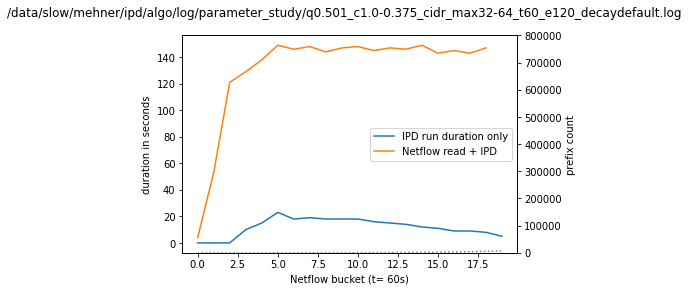

currently 26.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 97.73076923076923s; min: 3s; max: 109s


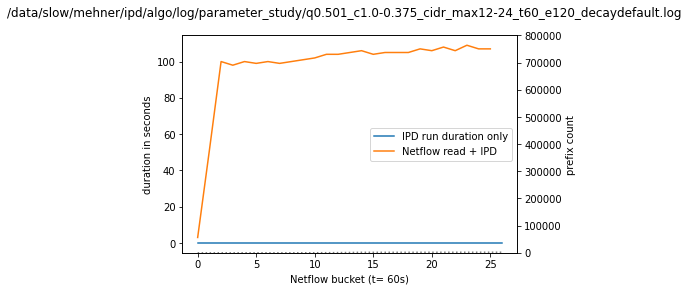

currently 0.0 minutes done
currently 25.0 minutes done
IPD run: avg: 0.0s; min: 0; max: 0
iteration run: avg: 98.32s; min: 4s; max: 110s


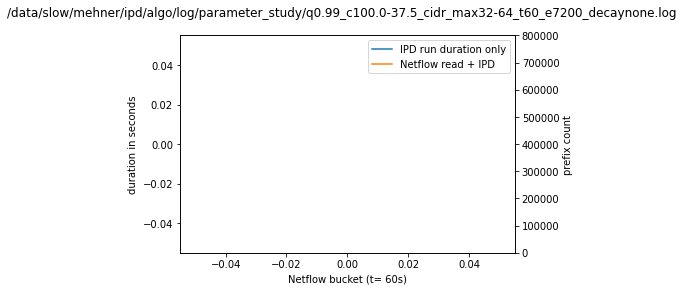

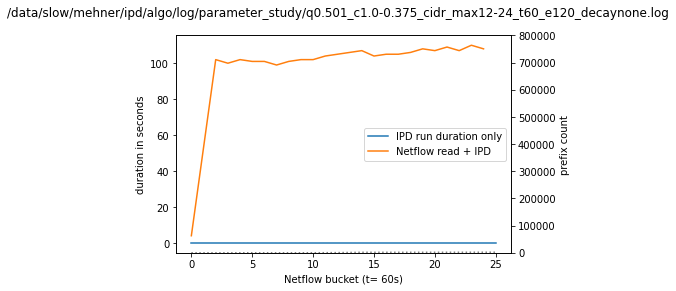

currently 21.0 minutes done
IPD run: avg: 5.045454545454546s; min: 0; max: 9
iteration run: avg: 116.04761904761905s; min: 3s; max: 130s


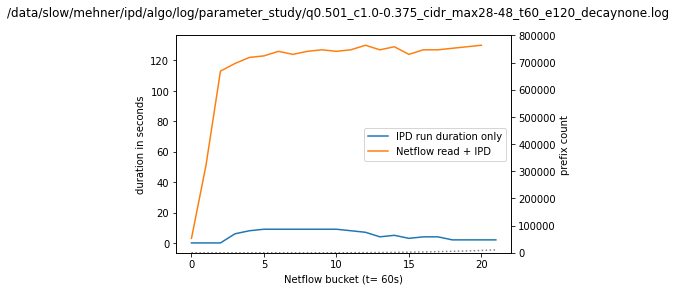

currently 21.0 minutes done
IPD run: avg: 5.045454545454546s; min: 0; max: 9
iteration run: avg: 115.57142857142857s; min: 4s; max: 130s


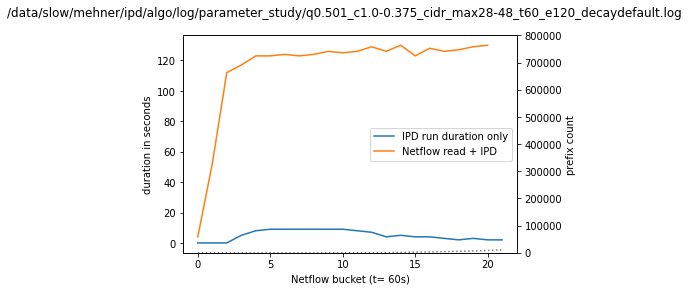

In [17]:
import datetime
from sys import prefix
import matplotlib.pyplot as plt
import  glob
import numpy as np
import socket
hostname = socket.gethostname()

logfile_path={
    'bithouse': "/data/slow/mehner/ipd/algo/log/parameter_study",
    'manni': "/home/stefan/WORK/ipd/algo/log/parameter_study", 
    'plum': ""}


### data stuff

format = "%Y-%m-%d %H:%M:%S,%f"

for logfile in glob.glob(f"{logfile_path.get(hostname)}/*"):
    try:
        file = open(logfile, 'r')
        Lines = file.readlines()

        count=0
        last_start_ts=None
        start_ts=None
        end_ts=None

        ipd_run_list=[]
        iteration_run_list=[]
        prefix_list=[]
        for line in Lines:
            count += 1
            # print("Line{}: {}".format(count, line.strip()))
            x = line.split(" ")

            ts=datetime.datetime.strptime(f"{x[0]} {x[1]}", format)
            #print(ts)
            if last_start_ts == None:   last_start_ts = ts
            if "run IPD" in line:
                start_ts=ts
                try:
                    prefix_list.append(int(x[-2]))
                except:
                    pass

                if last_start_ts != start_ts:
                    iteration_duration= start_ts- last_start_ts
                    if int(iteration_duration.seconds) > 600:
                        #print(x)
                        print(f"Caution: {last_start_ts} -> {start_ts}: netflow ts: {int(x[-5])} iteration run took extremly long: {iteration_duration}")
                    iteration_run_list.append(iteration_duration.seconds)
                    last_start_ts = start_ts
                
            elif "Finished" in line:
                end_ts=ts
                duration = end_ts - start_ts
                ipd_run_list.append(duration.seconds)

        ## plotting stuff
        # get t
        t = int(logfile.split("_t")[1].split("_e")[0])/60
        

        fig,ax = plt.subplots()
        ax.plot(ipd_run_list, label="IPD run duration only")
        ax.plot(iteration_run_list, label="Netflow read + IPD")
        # ax.set_xticklabels(np.arange(0, 1560, t))

        ax.set_xlabel(f"Netflow bucket (t= {int(t*60)}s)")
        ax.set_ylabel("duration in seconds")
        # ax.set_ylim(0, 500)
        # ax.set_xlim(0, 1560/t)
        
        plt.legend()

        ax2=ax.twinx()
        ax2.plot(prefix_list, label="prefix count", linestyle="dotted", color="grey")
        ax2.set_ylabel("prefix count")
        ax2.set_ylim(0, 800000)


        plt.suptitle(f"{logfile}")

        print(f"currently {len(iteration_run_list)*t} minutes done")
        print(f"IPD run: avg: {sum(ipd_run_list) / len(ipd_run_list)}s; min: {min(ipd_run_list)}; max: {max(ipd_run_list)}")
        print(f"iteration run: avg: {sum(iteration_run_list) / len(iteration_run_list)}s; min: {min(iteration_run_list)}s; max: {max(iteration_run_list)}s")
        plt.show()
    except: pass
